# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import retry
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
current_hour = datetime.datetime.utcnow().hour
are_today_results_partial = current_hour != 23

### Constants

In [3]:
from Modules.ExposureNotification import exposure_notification_io

spain_region_country_code = "ES"
germany_region_country_code = "DE"

default_backend_identifier = spain_region_country_code

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

### Parameters

In [4]:
environment_backend_identifier = os.environ.get("RADARCOVID_REPORT__BACKEND_IDENTIFIER")
if environment_backend_identifier:
    report_backend_identifier = environment_backend_identifier
else:
    report_backend_identifier = default_backend_identifier
report_backend_identifier

'ES'

In [5]:
environment_enable_multi_backend_download = \
    os.environ.get("RADARCOVID_REPORT__ENABLE_MULTI_BACKEND_DOWNLOAD")
if environment_enable_multi_backend_download:
    report_backend_identifiers = None
else:
    report_backend_identifiers = [report_backend_identifier]

report_backend_identifiers

In [6]:
environment_invalid_shared_diagnoses_dates = \
    os.environ.get("RADARCOVID_REPORT__INVALID_SHARED_DIAGNOSES_DATES")
if environment_invalid_shared_diagnoses_dates:
    invalid_shared_diagnoses_dates = environment_invalid_shared_diagnoses_dates.split(",")
else:
    invalid_shared_diagnoses_dates = []

invalid_shared_diagnoses_dates

['2020-10-30']

### COVID-19 Cases

In [7]:
report_backend_client = \
    exposure_notification_io.get_backend_client_with_identifier(
        backend_identifier=report_backend_identifier)

In [8]:
@retry.retry(tries=10, delay=10, backoff=1.1, jitter=(0, 10))
def download_cases_dataframe_from_ecdc():
    return pd.read_csv(
        "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv")

confirmed_df_ = download_cases_dataframe_from_ecdc()

In [9]:
confirmed_df = confirmed_df_.copy()
confirmed_df = confirmed_df[["dateRep", "cases", "geoId"]]
confirmed_df.rename(
    columns={
        "dateRep":"sample_date",
        "cases": "new_cases",
        "geoId": "country_code",
    },
    inplace=True)
confirmed_df["sample_date"] = pd.to_datetime(confirmed_df.sample_date, dayfirst=True)
confirmed_df["sample_date"] = confirmed_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases,country_code
6706,2020-11-14,1332,BA
23441,2020-11-14,4836,HU
51609,2020-11-14,185,UG
38037,2020-11-14,0,MP
0,2020-11-14,66,AF


In [10]:
def sort_source_regions_for_display(source_regions: list) -> list:
    if report_backend_identifier in source_regions:
        source_regions = [report_backend_identifier] + \
            list(sorted(set(source_regions).difference([report_backend_identifier])))
    else:
        source_regions = list(sorted(source_regions))
    return source_regions

In [11]:
report_source_regions = report_backend_client.source_regions_for_date(
    date=extraction_datetime.date())
report_source_regions = sort_source_regions_for_display(
    source_regions=report_source_regions)
report_source_regions

['ES', 'DE', 'DK', 'IE', 'IT', 'LV']

In [12]:
confirmed_days = pd.date_range(
    start=confirmed_df.iloc[0].sample_date,
    end=extraction_datetime)
confirmed_days_df = pd.DataFrame(data=confirmed_days, columns=["sample_date"])
confirmed_days_df["sample_date_string"] = \
    confirmed_days_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_days_df.tail()

,sample_date,sample_date_string
315,2020-11-10,2020-11-10
316,2020-11-11,2020-11-11
317,2020-11-12,2020-11-12
318,2020-11-13,2020-11-13
319,2020-11-14,2020-11-14


In [13]:
source_regions_at_date_df = confirmed_days_df.copy()
source_regions_at_date_df["source_regions_at_date"] = \
    source_regions_at_date_df.sample_date.apply(
        lambda x: report_backend_client.source_regions_for_date(date=x))
source_regions_at_date_df.sort_values("sample_date", inplace=True)
source_regions_at_date_df["_source_regions_group"] = source_regions_at_date_df. \
    source_regions_at_date.apply(lambda x: ",".join(sort_source_regions_for_display(x)))
source_regions_at_date_df.tail()

,sample_date,sample_date_string,source_regions_at_date,_source_regions_group
315,2020-11-10,2020-11-10,"{LV, IE, IT, DE, DK, ES}","ES,DE,DK,IE,IT,LV"
316,2020-11-11,2020-11-11,"{LV, IE, IT, DE, DK, ES}","ES,DE,DK,IE,IT,LV"
317,2020-11-12,2020-11-12,"{LV, IE, IT, DE, DK, ES}","ES,DE,DK,IE,IT,LV"
318,2020-11-13,2020-11-13,"{LV, IE, IT, DE, DK, ES}","ES,DE,DK,IE,IT,LV"
319,2020-11-14,2020-11-14,"{LV, IE, IT, DE, DK, ES}","ES,DE,DK,IE,IT,LV"


In [14]:
source_regions_for_summary_df = \
    source_regions_at_date_df[["sample_date", "_source_regions_group"]].copy()
source_regions_for_summary_df.rename(columns={"_source_regions_group": "source_regions"}, inplace=True)
source_regions_for_summary_df.tail()

,sample_date,source_regions
315,2020-11-10,"ES,DE,DK,IE,IT,LV"
316,2020-11-11,"ES,DE,DK,IE,IT,LV"
317,2020-11-12,"ES,DE,DK,IE,IT,LV"
318,2020-11-13,"ES,DE,DK,IE,IT,LV"
319,2020-11-14,"ES,DE,DK,IE,IT,LV"


In [15]:
confirmed_output_columns = ["sample_date", "new_cases", "covid_cases"]
confirmed_output_df = pd.DataFrame(columns=confirmed_output_columns)

for source_regions_group, source_regions_group_series in \
        source_regions_at_date_df.groupby("_source_regions_group"):
    source_regions_set = set(source_regions_group.split(","))
    confirmed_source_regions_set_df = \
        confirmed_df[confirmed_df.country_code.isin(source_regions_set)].copy()
    confirmed_source_regions_group_df = \
        confirmed_source_regions_set_df.groupby("sample_date").new_cases.sum() \
            .reset_index().sort_values("sample_date")
    confirmed_source_regions_group_df["covid_cases"] = \
        confirmed_source_regions_group_df.new_cases.rolling(7, min_periods=0).mean().round()
    confirmed_source_regions_group_df = \
        confirmed_source_regions_group_df[confirmed_output_columns]
    confirmed_source_regions_group_df.fillna(method="ffill", inplace=True)
    confirmed_source_regions_group_df = \
        confirmed_source_regions_group_df[
            confirmed_source_regions_group_df.sample_date.isin(
                source_regions_group_series.sample_date_string)]
    confirmed_output_df = confirmed_output_df.append(confirmed_source_regions_group_df)

confirmed_df = confirmed_output_df.copy()
confirmed_df.tail()

,sample_date,new_cases,covid_cases
309,2020-11-04,70966,66020.0
310,2020-11-05,73194,67010.0
311,2020-11-06,79454,68044.0
312,2020-11-07,62050,69596.0
313,2020-11-08,56547,71025.0


In [16]:
confirmed_df.rename(columns={"sample_date": "sample_date_string"}, inplace=True)
confirmed_df = confirmed_days_df[["sample_date_string"]].merge(confirmed_df, how="left")
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df.fillna(method="ffill", inplace=True)
confirmed_df.tail()

,sample_date_string,new_cases,covid_cases
315,2020-11-10,59124,72476.0
316,2020-11-11,74177,72741.0
317,2020-11-12,76143,73029.0
318,2020-11-13,84819,73621.0
319,2020-11-14,65322,73884.0


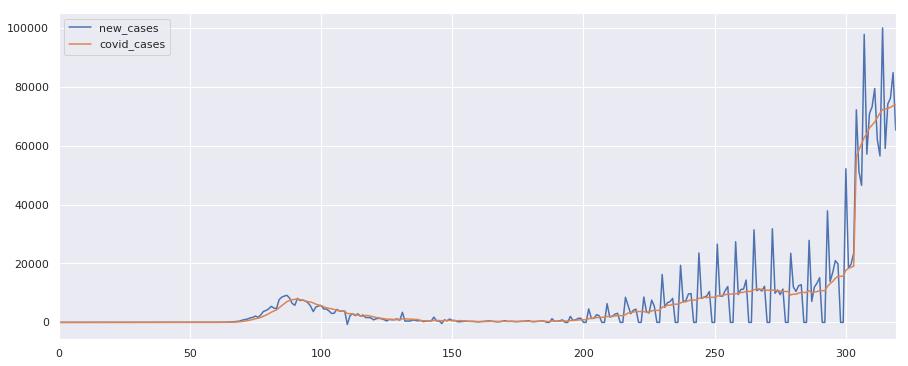

In [17]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [18]:
raw_zip_path_prefix = "Data/TEKs/Raw/"
fail_on_error_backend_identifiers = [report_backend_identifier]
multi_backend_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        backend_identifiers=report_backend_identifiers,
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=fail_on_error_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_backend_exposure_keys_df["region"] = multi_backend_exposure_keys_df["backend_identifier"]
multi_backend_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_backend_exposure_keys_df.head()

,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2020-11-14,2020-11-14,ES,V1,214,1.2.840.10045.4.3.2,bfda10d5-5dbf-fc4d-4180-ff68b4a5c0f9,2675520,132,0,ES
1,2020-11-14,2020-11-14,ES,V1,214,1.2.840.10045.4.3.2,2848fadb-e756-d73b-e505-92a0b5cd04dd,2675520,124,0,ES
2,2020-11-14,2020-11-14,ES,V1,214,1.2.840.10045.4.3.2,13e09564-0891-e7e7-a258-3efdad5c74de,2675520,130,0,ES
3,2020-11-14,2020-11-14,ES,V1,214,1.2.840.10045.4.3.2,622a99ef-609a-374f-1284-9f0b4ec30159,2675520,129,0,ES
4,2020-11-14,2020-11-14,ES,V1,214,1.2.840.10045.4.3.2,8dbdf46b-95bc-f0e0-4475-29a087b8d9a9,2675520,128,0,ES


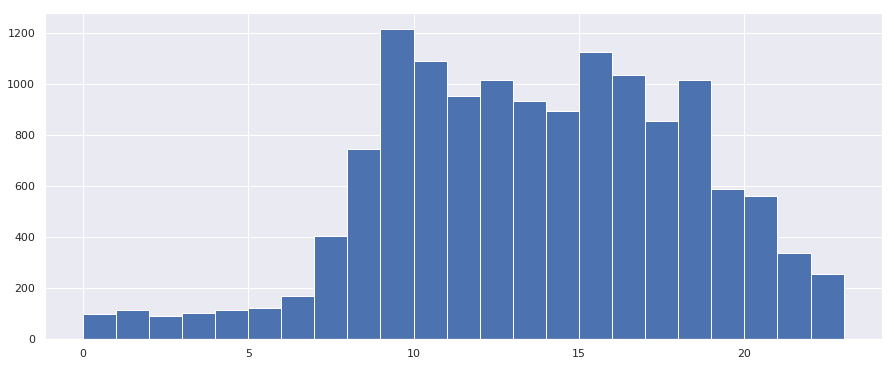

In [19]:
early_teks_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

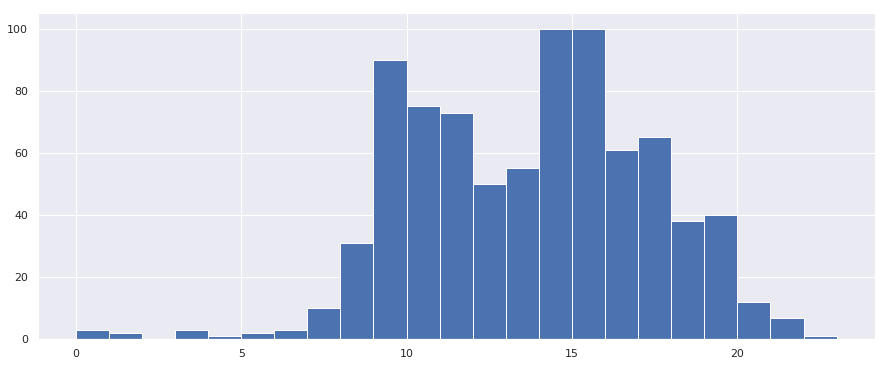

In [20]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [21]:
multi_backend_exposure_keys_df = multi_backend_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_backend_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2020-11-14,ES,bfda10d5-5dbf-fc4d-4180-ff68b4a5c0f9
1,2020-11-14,ES,2848fadb-e756-d73b-e505-92a0b5cd04dd
2,2020-11-14,ES,13e09564-0891-e7e7-a258-3efdad5c74de
3,2020-11-14,ES,622a99ef-609a-374f-1284-9f0b4ec30159
4,2020-11-14,ES,8dbdf46b-95bc-f0e0-4475-29a087b8d9a9


In [22]:
active_regions = \
    multi_backend_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['BE@TST', 'EE', 'MT', 'PT', 'BE', 'DK', 'ES@PRE', 'CH', 'DE', 'IT', 'ES']

In [23]:
multi_backend_summary_df = multi_backend_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_backend_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_backend_summary_df.rename_axis("sample_date", inplace=True)
multi_backend_summary_df = multi_backend_summary_df.fillna(0).astype(int)
multi_backend_summary_df = multi_backend_summary_df.head(backend_generation_days)
multi_backend_summary_df.head()

shared_teks_by_generation_date                                    \
region                                  BE BE@TST    CH    DE   DK  EE    ES   
sample_date                                                                    
2020-11-14                               0      0   595     0    0   0   211   
2020-11-13                               0      0  1280     0  194  24  1922   
2020-11-12                             116     44  1996  2501  355  45  4776   
2020-11-11                             157     44  2932  4837  537  65  7448   
2020-11-10                             262     50  3661  7101  725  78  9997   

                                    
region      ES@PRE    IT   MT   PT  
sample_date                         
2020-11-14       1    15    0    0  
2020-11-13      51  1576  105   77  
2020-11-12     341  4063  106  119  
2020-11-11     531  6323  112  151  
2020-11-10     748  8585  117  197

In [24]:
def compute_keys_cross_sharing(x):
    teks_x = x.key_data_x.item()
    common_teks = set(teks_x).intersection(x.key_data_y.item())
    common_teks_fraction = len(common_teks) / len(teks_x)
    return pd.Series(dict(
        common_teks=common_teks,
        common_teks_fraction=common_teks_fraction,
    ))

multi_backend_exposure_keys_by_region_df = \
    multi_backend_exposure_keys_df.groupby("region").key_data.unique().reset_index()
multi_backend_exposure_keys_by_region_df["_merge"] = True
multi_backend_exposure_keys_by_region_combination_df = \
    multi_backend_exposure_keys_by_region_df.merge(
        multi_backend_exposure_keys_by_region_df, on="_merge")
multi_backend_exposure_keys_by_region_combination_df.drop(
    columns=["_merge"], inplace=True)
if multi_backend_exposure_keys_by_region_combination_df.region_x.nunique() > 1:
    multi_backend_exposure_keys_by_region_combination_df = \
        multi_backend_exposure_keys_by_region_combination_df[
            multi_backend_exposure_keys_by_region_combination_df.region_x !=
            multi_backend_exposure_keys_by_region_combination_df.region_y]
multi_backend_exposure_keys_cross_sharing_df = \
    multi_backend_exposure_keys_by_region_combination_df \
        .groupby(["region_x", "region_y"]) \
        .apply(compute_keys_cross_sharing) \
        .reset_index()
multi_backend_cross_sharing_summary_df = \
    multi_backend_exposure_keys_cross_sharing_df.pivot_table(
        values=["common_teks_fraction"],
        columns="region_x",
        index="region_y",
        aggfunc=lambda x: x.item())
multi_backend_cross_sharing_summary_df

<ipython-input-24-4e21708c19d8>:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  teks_x = x.key_data_x.item()
<ipython-input-24-4e21708c19d8>:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  common_teks = set(teks_x).intersection(x.key_data_y.item())


<ipython-input-24-4e21708c19d8>:33: FutureWarning: `item` has been deprecated and will be removed in a future version
  aggfunc=lambda x: x.item())


common_teks_fraction                                            \
region_x                   BE BE@TST        CH        DE        DK   EE   
region_y                                                                  
BE                        NaN    0.0  0.000000  0.000000  0.000000  0.0   
BE@TST                    0.0    NaN  0.000000  0.000000  0.000000  0.0   
CH                        0.0    0.0       NaN  0.000040  0.000000  0.0   
DE                        0.0    0.0  0.000116       NaN  0.000000  0.0   
DK                        0.0    0.0  0.000000  0.000000       NaN  0.0   
EE                        0.0    0.0  0.000000  0.000000  0.000000  NaN   
ES                        0.0    0.0  0.000116  0.950886  0.412934  0.0   
ES@PRE                    0.0    0.0  0.000000  0.000000  0.000000  0.0   
IT                        0.0    0.0  0.000116  0.950886  0.000000  0.0   
MT                        0.0    0.0  0.000000  0.000000  0.000000  0.0   
PT                        0.0    0.0  0.000000  0.000000  0.000000  0.0   

                                               
region_x        ES ES@PRE        IT   MT   PT  
region_y                                       
BE        0.000000    0.0  0.000000  0.0  0.0  
BE@TST    0.000000    0.0  0.000000  0.0  0.0  
CH        0.000032    0.0  0.000036  0.0  0.0  
DE        0.765734    0.0  0.851874  0.0  0.0  
DK        0.032646    0.0  0.000000  0.0  0.0  
EE        0.000000    0.0  0.000000  0.0  0.0  
ES             NaN    0.0  0.988051  0.0  0.0  
ES@PRE    0.000000    NaN  0.000000  0.0  0.0  
IT        0.888141    0.0       NaN  0.0  0.0  
MT        0.000000    0.0  0.000000  NaN  0.0  
PT        0.000000    0.0  0.000000  0.0  NaN

In [25]:
multi_backend_without_active_region_exposure_keys_df = \
    multi_backend_exposure_keys_df[multi_backend_exposure_keys_df.region != report_backend_identifier]
multi_backend_without_active_region = \
    multi_backend_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_backend_without_active_region

['BE@TST', 'EE', 'MT', 'PT', 'BE', 'DK', 'ES@PRE', 'CH', 'DE', 'IT']

In [26]:
exposure_keys_summary_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.region == report_backend_identifier]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2020-11-14,211
2020-11-13,1922
2020-11-12,4776
2020-11-11,7448
2020-11-10,9997


### Dump API TEKs

In [27]:
tek_list_df = multi_backend_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-11-01,BE,"[00452feb-d482-1ba3-ec69-90cc788f8d49, 0387843...",2020-11-14,2020-11-14@23
1,2020-11-01,BE@TST,"[03921b0f-ea35-494a-2a94-b535c566e79d, 09e033e...",2020-11-14,2020-11-14@23
2,2020-11-01,CH,"[d13b47ed-1c8b-cde5-c9ef-6567e94f751e, a3266dd...",2020-11-14,2020-11-14@23
3,2020-11-01,DE,"[0020b965-e875-5324-f71d-4ad059ad3881, 00321ec...",2020-11-14,2020-11-14@23
4,2020-11-01,DK,"[c946ddf1-09c5-3e21-fcb1-25a77db99537, bdf6f78...",2020-11-14,2020-11-14@23


### Load TEK Dumps

In [28]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    file_paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        file_paths = file_paths[:limit]
    for file_path in file_paths:
        logging.info(f"Loading TEKs from '{file_path}'...")
        iteration_extracted_teks_df = pd.read_json(file_path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [29]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=report_backend_identifier,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
6,ES,2020-11-01,"[c62e146d-80cd-7e74-9233-7efa5f66cfdb, 9d1f2f8...",2020-11-14,NaN
17,ES,2020-11-02,"[beb79694-723f-04ca-57cc-e572afae4d3d, b52d9fb...",2020-11-14,NaN
28,ES,2020-11-03,"[c82b1637-d436-414e-f179-9425882f4b2e, c72b0d3...",2020-11-14,NaN
39,ES,2020-11-04,"[90d0aa95-6413-e8a9-9aae-cb002888980e, 68674f8...",2020-11-14,NaN
50,ES,2020-11-05,"[c6004831-51a3-e9d9-febd-f87b71052d60, 2205cd4...",2020-11-14,NaN


In [30]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-11-14,211
2020-11-13,1922
2020-11-12,4776
2020-11-11,7448
2020-11-10,9997


### Daily New TEKs

In [31]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{64a4f810-38f3-c404-c579-06936fe5f375, af3e664..."
2020-08-30,"{64a4f810-38f3-c404-c579-06936fe5f375, af3e664..."
2020-08-31,"{64a4f810-38f3-c404-c579-06936fe5f375, af3e664..."
2020-09-01,"{64a4f810-38f3-c404-c579-06936fe5f375, af3e664..."
2020-09-02,"{64a4f810-38f3-c404-c579-06936fe5f375, af3e664..."


In [32]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-32-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
10,2020-08-30,2020-08-29,16,1
9,2020-08-30,2020-08-28,5,2
8,2020-08-30,2020-08-27,3,3
7,2020-08-30,2020-08-26,3,4
6,2020-08-30,2020-08-25,2,5


In [33]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
50,2020-11-14,2020-11-05,1613,9
39,2020-11-14,2020-11-04,1573,10
28,2020-11-14,2020-11-03,1534,11
17,2020-11-14,2020-11-02,1502,12
6,2020-11-14,2020-11-01,1475,13


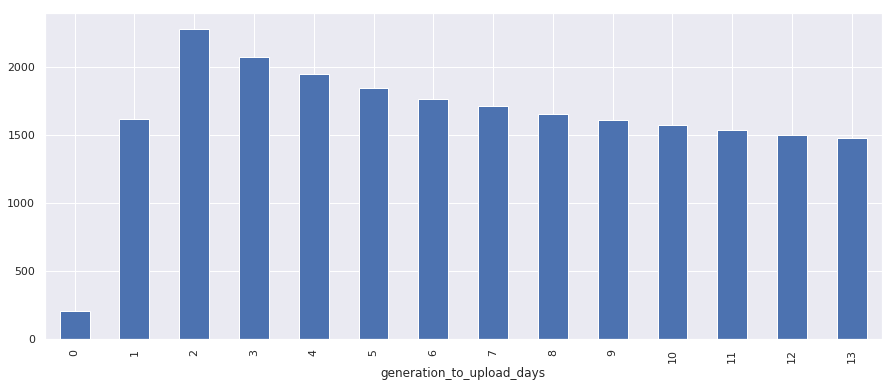

In [34]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [35]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2020-11-14,211,1616,2281,2074,1947,1842,1765,1710,1655,1613,1573,1534,1502,1475
2020-11-13,306,2178,2890,2669,2521,2378,2281,2224,2163,2110,2066,2025,1970,1948
2020-11-12,317,2184,3205,2915,2701,2606,2490,2410,2319,2236,2183,2113,2074,2039
2020-11-11,300,1884,3029,2726,2628,2523,2420,2318,2240,2172,2116,2072,2027,1990
2020-11-10,292,1466,2086,2003,1908,1781,1667,1569,1505,1455,1409,1374,1350,1298


In [36]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
73,2020-11-10,21163.0
74,2020-11-11,30445.0
75,2020-11-12,31792.0
76,2020-11-13,29729.0
77,2020-11-14,22798.0


In [37]:
shared_teks_uploaded_on_generation_date_df = shared_teks_generation_to_upload_df[
    shared_teks_generation_to_upload_df.generation_to_upload_days == 0] \
    [["upload_date", "shared_teks"]].rename(
    columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
141,2020-11-14,211
141,2020-11-13,306
142,2020-11-12,317
142,2020-11-11,300
141,2020-11-10,292


In [38]:
estimated_shared_diagnoses_df = shared_teks_generation_to_upload_df \
    .groupby(["upload_date"]).shared_teks.max().reset_index() \
    .sort_values(["upload_date"], ascending=False) \
    .rename(columns={
        "upload_date": "sample_date_string",
        "shared_teks": "shared_diagnoses",
    })
invalid_shared_diagnoses_dates_mask = \
    estimated_shared_diagnoses_df.sample_date_string.isin(invalid_shared_diagnoses_dates)
estimated_shared_diagnoses_df[invalid_shared_diagnoses_dates_mask] = 0
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
76,2020-11-14,2281
75,2020-11-13,2890
74,2020-11-12,3205
73,2020-11-11,3029
72,2020-11-10,2086


### Hourly New TEKs

In [39]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=report_backend_identifier, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
6,ES,2020-11-01,"[c62e146d-80cd-7e74-9233-7efa5f66cfdb, 9d1f2f8...",2020-11-14,2020-11-14@23
17,ES,2020-11-02,"[beb79694-723f-04ca-57cc-e572afae4d3d, b52d9fb...",2020-11-14,2020-11-14@23
28,ES,2020-11-03,"[c82b1637-d436-414e-f179-9425882f4b2e, c72b0d3...",2020-11-14,2020-11-14@23
39,ES,2020-11-04,"[90d0aa95-6413-e8a9-9aae-cb002888980e, 68674f8...",2020-11-14,2020-11-14@23
50,ES,2020-11-05,"[c6004831-51a3-e9d9-febd-f87b71052d60, 2205cd4...",2020-11-14,2020-11-14@23


In [40]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-11-13@23,0
1,2020-11-14@00,24
2,2020-11-14@01,0
3,2020-11-14@02,32
4,2020-11-14@03,0


In [41]:
hourly_summary_df = hourly_new_tek_count_df.copy()
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
datetime_utc,,
2020-11-14 00:00:00,2020-11-14@00,24
2020-11-14 01:00:00,2020-11-14@01,0
2020-11-14 02:00:00,2020-11-14@02,32
2020-11-14 03:00:00,2020-11-14@03,0
2020-11-14 04:00:00,2020-11-14@04,28


### Data Merge

In [42]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-11-14,211,22798.0
1,2020-11-13,1922,29729.0
2,2020-11-12,4776,31792.0
3,2020-11-11,7448,30445.0
4,2020-11-10,9997,21163.0


In [43]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-11-14,211,22798.0,211.0
1,2020-11-13,1922,29729.0,306.0
2,2020-11-12,4776,31792.0,317.0
3,2020-11-11,7448,30445.0,300.0
4,2020-11-10,9997,21163.0,292.0


In [44]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-11-14,211.0,22798.0,211.0,2281.0
1,2020-11-13,1922.0,29729.0,306.0,2890.0
2,2020-11-12,4776.0,31792.0,317.0,3205.0
3,2020-11-11,7448.0,30445.0,300.0,3029.0
4,2020-11-10,9997.0,21163.0,292.0,2086.0


In [45]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-08-23,0,6177.0,28.0,NaN,NaN,NaN
1,2020-08-24,19382,6622.0,48.0,NaN,NaN,NaN
2,2020-08-25,7117,6908.0,58.0,NaN,NaN,NaN
3,2020-08-26,7296,6997.0,75.0,NaN,NaN,NaN
4,2020-08-27,9658,7372.0,72.0,NaN,NaN,NaN


In [46]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df = result_summary_df.merge(source_regions_for_summary_df, how="left")
result_summary_df.set_index(["sample_date", "source_regions"], inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,source_regions,,,,,,
2020-11-14,"ES,DE,DK,IE,IT,LV",65322,73884.0,211.0,22798.0,211.0,2281.0
2020-11-13,"ES,DE,DK,IE,IT,LV",84819,73621.0,1922.0,29729.0,306.0,2890.0
2020-11-12,"ES,DE,DK,IE,IT,LV",76143,73029.0,4776.0,31792.0,317.0,3205.0
2020-11-11,"ES,DE,DK,IE,IT,LV",74177,72741.0,7448.0,30445.0,300.0,3029.0
2020-11-10,"ES,DE,DK,IE,IT,LV",59124,72476.0,9997.0,21163.0,292.0,2086.0


In [47]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)

result_summary_df.head(daily_plot_days)

,,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,source_regions,,,,,,,,
2020-11-14,"ES,DE,DK,IE,IT,LV",65322,73884,211,22798,211,2281,9.994739,0.030873
2020-11-13,"ES,DE,DK,IE,IT,LV",84819,73621,1922,29729,306,2890,10.286851,0.039255
2020-11-12,"ES,DE,DK,IE,IT,LV",76143,73029,4776,31792,317,3205,9.919501,0.043887
2020-11-11,"ES,DE,DK,IE,IT,LV",74177,72741,7448,30445,300,3029,10.051172,0.041641
2020-11-10,"ES,DE,DK,IE,IT,LV",59124,72476,9997,21163,292,2086,10.145254,0.028782
2020-11-09,"ES,DE,DK,IE,IT,LV",100008,72329,12009,16517,236,1683,9.814023,0.023269
2020-11-08,"ES,DE,IE,IT,LV",56547,71025,12991,16816,209,1809,9.295744,0.025470
2020-11-07,"ES,DE,IE,IT,LV",62050,69596,14153,23688,313,2490,9.513253,0.035778
2020-11-06,"ES,DE,IE,IT,LV",79454,68044,15822,28583,263,2909,9.825713,0.042752


In [48]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)

with pd.option_context("mode.use_inf_as_na", True):
    weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
    weekly_result_summary_df["teks_per_shared_diagnosis"] = \
        (weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses).fillna(0)
    weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
        (weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases).fillna(0)

weekly_result_summary_df.head()

,,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,source_regions,,,,,,
2020-11-14,"ES,DE,DK,IE,IT,LV",509105,49354,169260,16983,9.966437,0.033359
2020-11-13,"ES,DE,DK,IE,IT,LV",504817,63296,170150,17192,9.897045,0.034056
2020-11-12,"ES,DE,DK,IE,IT,LV",499240,77196,169004,17211,9.819534,0.034474
2020-11-11,"ES,DE,DK,IE,IT,LV",493221,90391,163785,16702,9.806311,0.033863
2020-11-10,"ES,DE,DK,IE,IT,LV",486500,102957,161587,16524,9.778928,0.033965


In [49]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[1]
last_7_days_summary

{'covid_cases': 504817,
 'shared_teks_by_generation_date': 63296,
 'shared_teks_by_upload_date': 170150,
 'shared_diagnoses': 17192,
 'teks_per_shared_diagnosis': 9.89704513727315,
 'shared_diagnoses_per_covid_case': 0.03405590540730601}

## Report Results

In [50]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "source_regions": "Source Countries",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend",
    "region_x": "Backend\u00A0(A)",
    "region_y": "Backend\u00A0(B)",
    "common_teks": "Common TEKs Shared Between Backends",
    "common_teks_fraction": "Fraction of TEKs in Backend (A) Available in Backend (B)",
    "covid_cases": "COVID-19 Cases in Source Countries (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [51]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [52]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,,COVID-19 Cases in Source Countries (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)
Sample Date (UTC),Source Countries,,,,,,,
2020-11-14,"ES,DE,DK,IE,IT,LV",73884,211,22798,211,2281,9.994739,0.030873
2020-11-13,"ES,DE,DK,IE,IT,LV",73621,1922,29729,306,2890,10.286851,0.039255
2020-11-12,"ES,DE,DK,IE,IT,LV",73029,4776,31792,317,3205,9.919501,0.043887
2020-11-11,"ES,DE,DK,IE,IT,LV",72741,7448,30445,300,3029,10.051172,0.041641
2020-11-10,"ES,DE,DK,IE,IT,LV",72476,9997,21163,292,2086,10.145254,0.028782
...,...,...,...,...,...,...,...,...
2020-08-27,ES,7372,72,0,0,0,0.000000,0.000000
2020-08-26,ES,6997,75,0,0,0,0.000000,0.000000
2020-08-25,ES,6908,58,0,0,0,0.000000,0.000000


### Daily Summary Plots

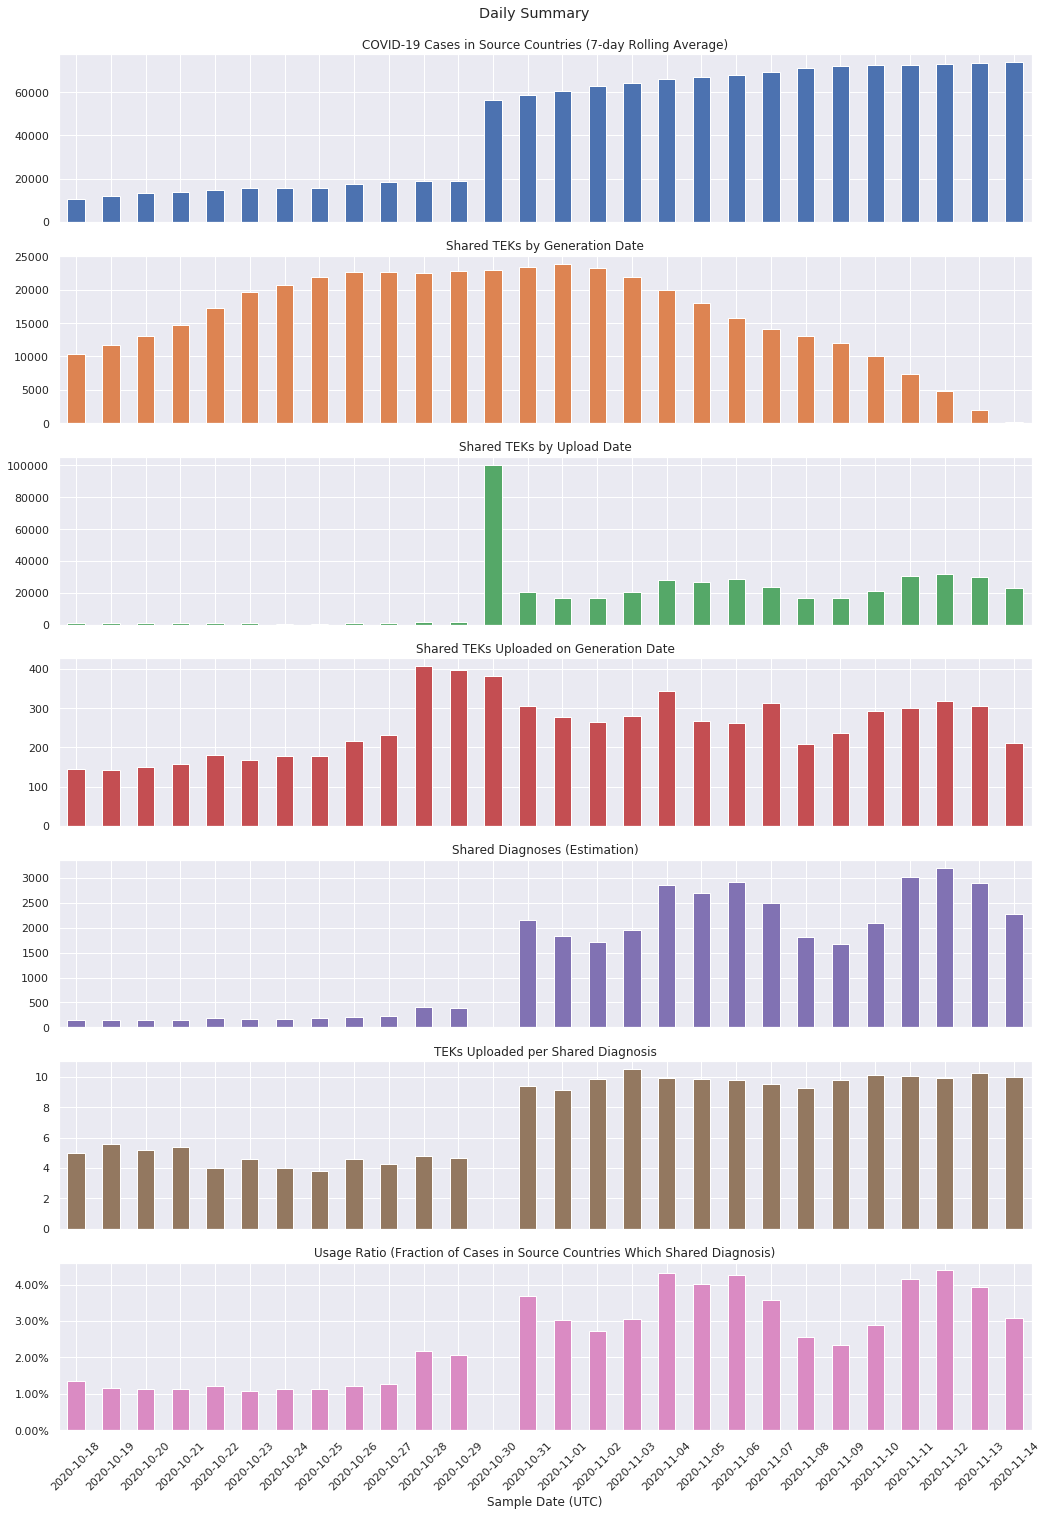

In [53]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .droplevel(level=["source_regions"]) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Daily Generation to Upload Period Table

In [54]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2020-11-14,211,1616,2281,2074,1947,1842,1765,1710,1655,1613,1573,1534,1502,1475
2020-11-13,306,2178,2890,2669,2521,2378,2281,2224,2163,2110,2066,2025,1970,1948
2020-11-12,317,2184,3205,2915,2701,2606,2490,2410,2319,2236,2183,2113,2074,2039
2020-11-11,300,1884,3029,2726,2628,2523,2420,2318,2240,2172,2116,2072,2027,1990
2020-11-10,292,1466,2086,2003,1908,1781,1667,1569,1505,1455,1409,1374,1350,1298
2020-11-09,236,1126,1683,1602,1480,1384,1285,1215,1168,1127,1108,1059,1034,1010
2020-11-08,209,929,1809,1640,1502,1394,1315,1247,1202,1167,1141,1119,1081,1061
2020-11-07,313,1348,2490,2247,2086,1959,1838,1775,1724,1670,1624,1581,1532,1501
2020-11-06,263,1707,2909,2688,2509,2343,2255,2182,2116,2049,1967,1912,1857,1826


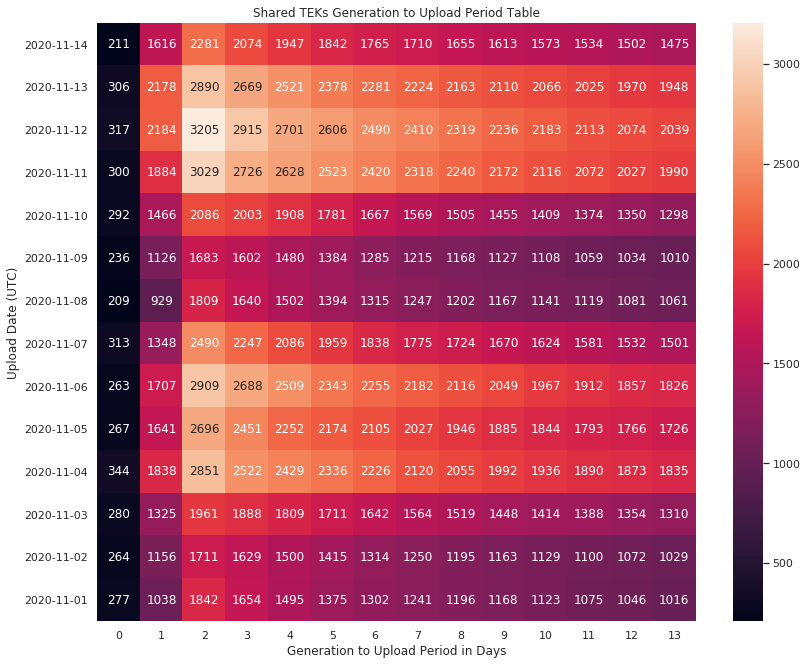

In [55]:
fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(12, 1 + 0.6 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

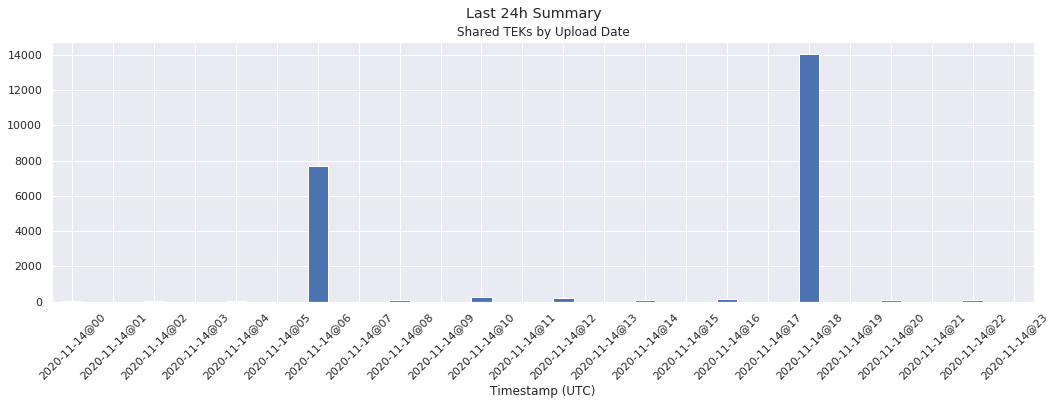

In [56]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [57]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [58]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
}
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_backend_summary_table_html = multi_backend_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

def format_multi_backend_cross_sharing_fraction(x):
    if pd.isna(x):
        return "-"
    elif round(x * 100, 1) == 0:
        return ""
    else:
        return f"{x:.1%}"

multi_backend_cross_sharing_summary_table_html = multi_backend_cross_sharing_summary_df \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(
        classes="table-center",
        formatters=display_formatters,
        float_format=format_multi_backend_cross_sharing_fraction)
multi_backend_cross_sharing_summary_table_html = \
    multi_backend_cross_sharing_summary_table_html \
        .replace("<tr>","<tr style=\"text-align: center;\">")

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index.get_level_values("sample_date") == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.item()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.item()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.item()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.item()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.item()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.item()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)

display_source_regions = ", ".join(report_source_regions)
if len(report_source_regions) == 1:
    display_brief_source_regions = report_source_regions[0]
else:
    display_brief_source_regions = f"{len(report_source_regions)} 🇪🇺"

<ipython-input-58-bd16b454de40>:49: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.covid_cases.item()
<ipython-input-58-bd16b454de40>:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_teks_by_generation_date.item()
<ipython-input-58-bd16b454de40>:53: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_teks_by_upload_date.item()
<ipython-input-58-bd16b454de40>:55: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.shared_diagnoses.item()
<ipython-input-58-bd16b454de40>:57: FutureWarning: `item` has been deprecated and will be removed in a future version
  extraction_date_result_summary_df.teks_per_shared_diagnosis.item()
<ipython-input-58-bd16b454de40>:59: FutureWarning: `item` has been deprecated and 

In [59]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_backend_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_backend_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [60]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_backend_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Summary-Table.csv")
multi_backend_cross_sharing_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Cross-Sharing-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_backend_summary_table_image_path,
    report_resources_path_prefix + "Multi-Backend-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [61]:
def generate_summary_api_results(df: pd.DataFrame) -> list:
    api_df = df.reset_index().copy()
    api_df["sample_date_string"] = \
        api_df["sample_date"].dt.strftime("%Y-%m-%d")
    api_df["source_regions"] = \
        api_df["source_regions"].apply(lambda x: x.split(","))
    return api_df.to_dict(orient="records")

summary_api_results = \
    generate_summary_api_results(df=result_summary_df)
today_summary_api_results = \
    generate_summary_api_results(df=extraction_date_result_summary_df)[0]

summary_results = dict(
    backend_identifier=report_backend_identifier,
    source_regions=report_source_regions,
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=0,
    ),
    today=today_summary_api_results,
    last_7_days=last_7_days_summary,
    daily_results=summary_api_results)

summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [62]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_backend_summary_table_html=multi_backend_summary_table_html,
    multi_backend_cross_sharing_summary_table_html=multi_backend_cross_sharing_summary_table_html,
    display_source_regions=display_source_regions)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [63]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule" and \
        (shared_teks_by_upload_date_last_hour or not are_today_results_partial):
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    if are_today_results_partial:
        today_addendum = " (Partial)"
    else:
        today_addendum = ""

    status = textwrap.dedent(f"""
        #RadarCOVID – {extraction_date_with_hour}

        Source Countries: {display_brief_source_regions}

        Today{today_addendum}:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f}
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Last 7 Days:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)